In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
raw_csv_data=pd.read_csv("malaysia_house_price_data_2025_label_encoded.csv")
df_encoded=raw_csv_data.copy()

# --- Split features and target ---
X = df_encoded.drop(columns='Median_Price')
y = df_encoded['Median_Price']

# Check target distribution
print("Target statistics:")
print(y.describe())
print(f"\nTarget range: {y.min():,.0f} to {y.max():,.0f}")

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Scale features - Using RobustScaler for better outlier handling ---
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- ALSO SCALE THE TARGET VARIABLE ---
# This is crucial! The target values are very large, causing numerical instability
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"\nScaled y_train range: {y_train_scaled.min():.2f} to {y_train_scaled.max():.2f}")


Target statistics:
count    2.000000e+03
mean     4.906854e+05
std      4.686322e+05
min      2.704900e+04
25%      2.699500e+05
50%      3.900000e+05
75%      5.735000e+05
max      1.142050e+07
Name: Median_Price, dtype: float64

Target range: 27,049 to 11,420,500

Scaled y_train range: -0.97 to 22.77


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Advanced Deep Learning Model with Multiple Branches ---
input_layer = Input(shape=(X_train_scaled.shape[1],))

# --- WIDE PATH (Linear model) ---
wide_path = layers.Dense(1, use_bias=True, kernel_regularizer=keras.regularizers.l2(1e-5))(input_layer)

# --- DEEP PATH 1: Branch with Swish activation ---
# Branch 1: Larger capacity
branch1 = layers.Dense(512, activation='swish', kernel_regularizer=keras.regularizers.l2(1e-4))(input_layer)
branch1 = layers.BatchNormalization()(branch1)
branch1 = layers.Dropout(0.3)(branch1)

branch1 = layers.Dense(256, activation='swish', kernel_regularizer=keras.regularizers.l2(1e-4))(branch1)
branch1 = layers.BatchNormalization()(branch1)
branch1 = layers.Dropout(0.25)(branch1)

branch1 = layers.Dense(128, activation='swish', kernel_regularizer=keras.regularizers.l2(1e-4))(branch1)
branch1 = layers.BatchNormalization()(branch1)
branch1_output = layers.Dropout(0.2)(branch1)

# --- DEEP PATH 2: Branch with ReLU and residual connection ---
# Branch 2
branch2 = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(input_layer)
branch2 = layers.BatchNormalization()(branch2)
branch2 = layers.Dropout(0.3)(branch2)

branch2_shortcut = branch2  # Save for residual connection

branch2 = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(branch2)
branch2 = layers.BatchNormalization()(branch2)
branch2 = layers.Dropout(0.25)(branch2)

# Residual connection (dimensions match)
branch2 = layers.Add()([branch2, branch2_shortcut])

branch2 = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(branch2)
branch2 = layers.BatchNormalization()(branch2)
branch2_output = layers.Dropout(0.2)(branch2)

# --- DEEP PATH 3: Branch with ELU activation ---
branch3 = layers.Dense(128, activation='elu', kernel_regularizer=keras.regularizers.l2(1e-4))(input_layer)
branch3 = layers.BatchNormalization()(branch3)
branch3 = layers.Dropout(0.3)(branch3)

branch3 = layers.Dense(64, activation='elu', kernel_regularizer=keras.regularizers.l2(1e-4))(branch3)
branch3 = layers.BatchNormalization()(branch3)
branch3 = layers.Dropout(0.25)(branch3)

branch3 = layers.Dense(32, activation='elu', kernel_regularizer=keras.regularizers.l2(1e-4))(branch3)
branch3 = layers.BatchNormalization()(branch3)
branch3_output = layers.Dropout(0.2)(branch3)

# --- Combine all branches ---
# Process branch outputs to same dimension for concatenation
branch1_final = layers.Dense(64, activation='relu')(branch1_output)
branch2_final = layers.Dense(64, activation='relu')(branch2_output)
branch3_final = layers.Dense(64, activation='relu')(branch3_output)

# Concatenate all branch outputs
concat_paths = layers.Concatenate()([branch1_final, branch2_final, branch3_final])

# Final processing layers
deep_path = layers.Dense(256, activation='swish', kernel_regularizer=keras.regularizers.l2(1e-4))(concat_paths)
deep_path = layers.BatchNormalization()(deep_path)
deep_path = layers.Dropout(0.2)(deep_path)

deep_path = layers.Dense(128, activation='swish', kernel_regularizer=keras.regularizers.l2(1e-4))(deep_path)
deep_path = layers.BatchNormalization()(deep_path)
deep_path = layers.Dropout(0.15)(deep_path)

deep_path = layers.Dense(64, activation='swish', kernel_regularizer=keras.regularizers.l2(1e-4))(deep_path)
deep_path = layers.BatchNormalization()(deep_path)
deep_path = layers.Dropout(0.1)(deep_path)

deep_path = layers.Dense(1)(deep_path)

# --- Combine Wide and Deep paths ---
combined = layers.Add()([wide_path, deep_path])

# Create the model
model = Model(inputs=input_layer, outputs=combined)

# --- Compile with Huber loss (more robust to outliers) ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss='huber',  # More robust to outliers than MSE
    metrics=['mae', 'mse']
)

# --- Define callbacks ---
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1,
        cooldown=3
    )
]

# --- Model summary ---
model.summary()


c:\Users\LIM TZE TA\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\LIM TZE TA\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\LIM TZE TA\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorfl

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      2,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │      4,096 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      1,024 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     65,792 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout_4[0][0],  │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0] 

 Total params: 398,505 (1.52 MB)

 Trainable params: 394,089 (1.50 MB)

 Non-trainable params: 4,416 (17.25 KB)

In [3]:
# Train the model with scaled targets and callbacks
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.15,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.7293 - mae: 0.9461 - mse: 1.9906 - val_loss: 0.7247 - val_mae: 0.9481 - val_mse: 1.8441 - learning_rate: 0.0010
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5770 - mae: 0.7670 - mse: 1.4120 - val_loss: 0.7051 - val_mae: 0.9242 - val_mse: 1.7790 - learning_rate: 0.0010
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5063 - mae: 0.6690 - mse: 1.2280 - val_loss: 0.6618 - val_mae: 0.8764 - val_mse: 1.6093 - learning_rate: 0.0010
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4564 - mae: 0.6033 - mse: 1.0804 - val_loss: 0.6441 - val_mae: 0.8537 - val_mse: 1.5512 - learning_rate: 0.0010
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4517 - mae: 0.5910 - mse: 1.1404 - val_loss: 0.6076 - val_mae: 0.8110 - val_mse: 1.4215 - learning_rate: 0.0010
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4191 - mae: 0.5497 - mse: 0.8963 - val_loss: 0.5655 - val_mae: 0.76

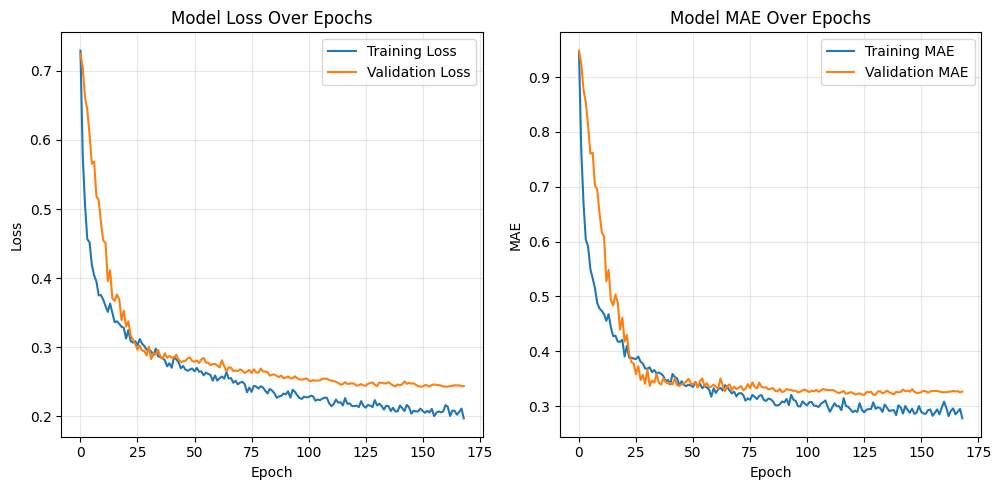

In [4]:
# Plot training history
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate (if tracked)
if 'lr' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on scaled data
y_pred_scaled = model.predict(X_test_scaled).flatten()

# Transform predictions back to original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"\nMAE as percentage of mean: {(mae / y_test.mean()) * 100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
MAE: 148030.34
RMSE: 309696.96
R²: 0.4548

MAE as percentage of mean: 30.58%


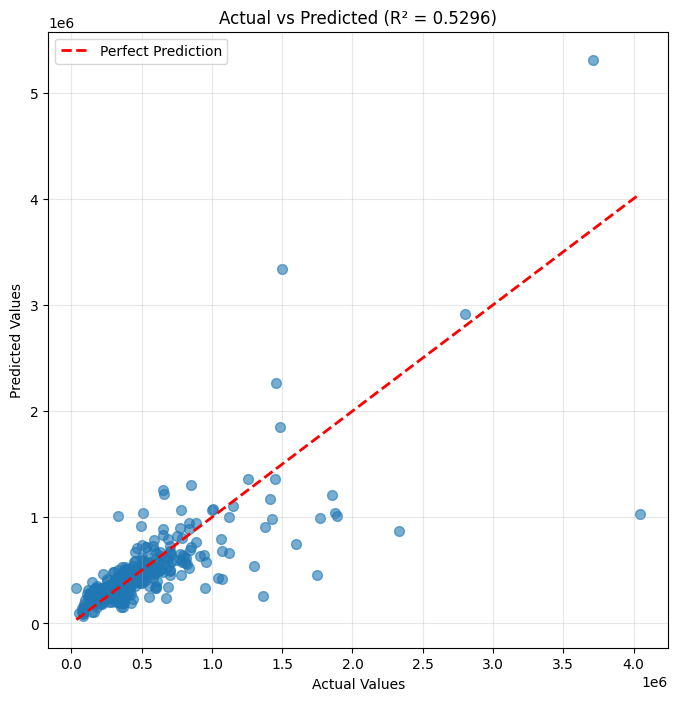

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted (R² = {r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


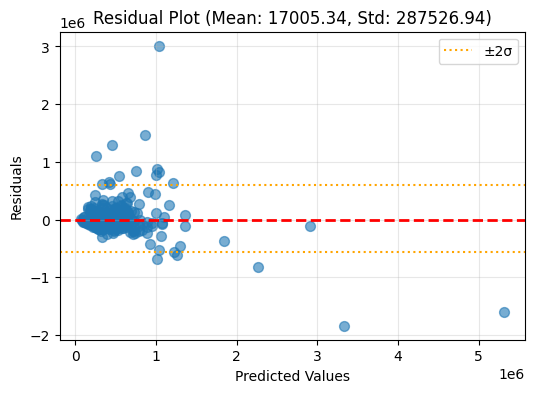

In [21]:
residuals = y_test - y_pred

# Calculate residual statistics
residual_mean = residuals.mean()
residual_std = residuals.std()

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6, s=50)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.axhline(residual_mean + 2*residual_std, color='orange', linestyle=':', label='±2σ')
plt.axhline(residual_mean - 2*residual_std, color='orange', linestyle=':')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot (Mean: {residual_mean:.2f}, Std: {residual_std:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



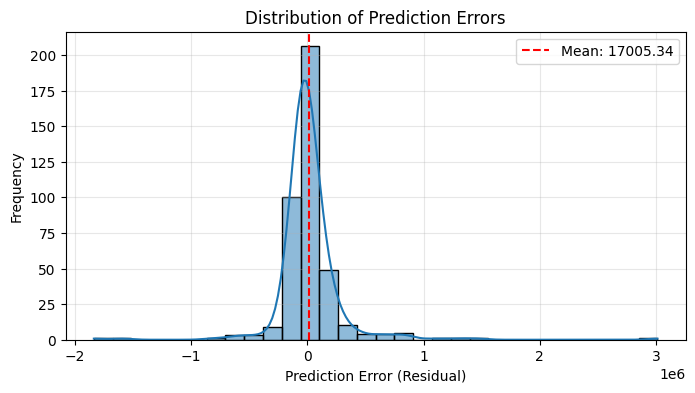

In [22]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(residual_mean, color='r', linestyle='--', label=f'Mean: {residual_mean:.2f}')
plt.xlabel('Prediction Error (Residual)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


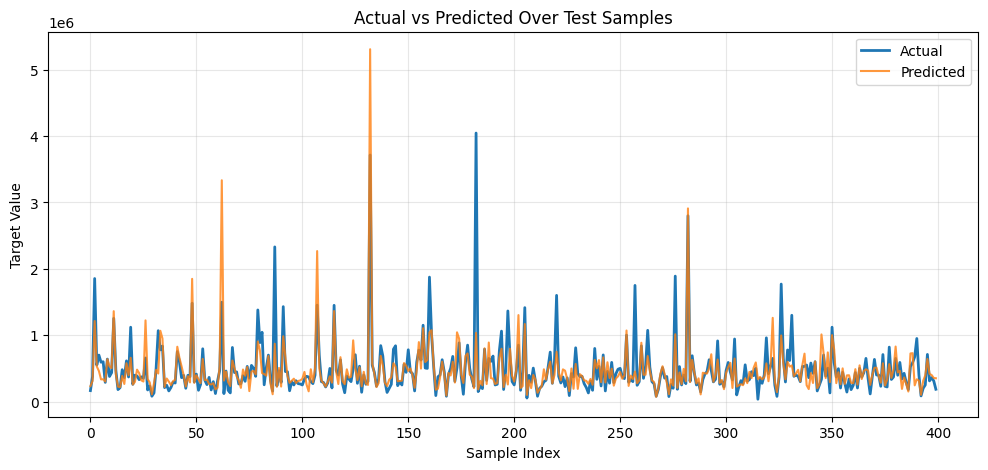

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', alpha=0.8, linewidth=1.5)
plt.title('Actual vs Predicted Over Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
